# Disclaimer

This can only properly be run on a heavy duty PC

In [1]:
training_rows_to_read = 5000000 # This needs to be 15000000

# Imports

In [2]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()

from datetime import datetime, timedelta

Preprocessing successfully imported.


In [3]:
# data_object = Preprocessing.read_data(rows_to_read = None, columns = ["b2c_c2c"])
# data_object = Preprocessing.read_data(rows_to_read = None)
training_data = preprocessing.read_data(rows_to_read = training_rows_to_read)["train"]
print(training_data.columns)

Reading 5000000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')


# Setting up pipeline

## Target column

The objective is to estimate the total number of calendar days (after payment) it will take to have a purchased item show up at the buyer’s address. This is equivalent to estimating the delivery date using the formula:

payment date (local time) + delivery calendar days = delivery date (local time).

Participants should provide this delivery date in their submissions.

_Now to generate target column_

### Run the basic preprocessing steps

In [4]:
training_data = preprocessing.basic_preprocessing(training_data)

Finished parse_datetime_columns
Finished create_delivery_calendar_days
Finished clean_zip_codes


In [5]:
training_data["delivery_calendar_days"].describe()

count    5.000000e+06
mean     4.744181e+00
std      3.096501e+00
min     -1.520000e+02
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      2.140000e+02
Name: delivery_calendar_days, dtype: float64

In [6]:
training_data[training_data["delivery_calendar_days"] < 0][["payment_datetime", "delivery_date", "delivery_calendar_days"]]

,payment_datetime,delivery_date,delivery_calendar_days
166637,2018-11-02 10:18:28-07:00,2018-09-13,-50
259023,2018-07-11 06:41:35-06:00,2018-07-06,-5
533083,2019-03-31 22:28:25-07:00,2019-03-22,-9
590655,2019-08-23 01:04:47-05:00,2019-08-22,-1
604185,2018-05-05 05:47:29-07:00,2018-01-08,-117
...,...,...,...
4799824,2018-08-19 23:44:43-04:00,2018-08-16,-3
4893592,2018-01-04 18:48:54-08:00,2017-12-18,-17
4920385,2019-08-12 18:17:31-07:00,2019-08-08,-4
4962627,2018-06-01 16:37:12-04:00,2018-05-24,-8


In [7]:
training_data = training_data[training_data["delivery_calendar_days"] >= 0]

In [8]:
for col in training_data.columns:
    print(f"{col} : {len(training_data[col].unique())}")

b2c_c2c : 2
seller_id : 1000593
declared_handling_days : 12
acceptance_scan_timestamp : 723667
shipment_method_id : 24
shipping_fee : 5425
carrier_min_estimate : 6
carrier_max_estimate : 6
item_zip : 42412
buyer_zip : 43068
category_id : 33
item_price : 28894
quantity : 107
payment_datetime : 4729525
delivery_date : 747
weight : 982
weight_units : 2
package_size : 6
record_number : 4999924
delivery_calendar_days : 139
cleaned_item_zip : 33059
cleaned_buyer_zip : 36528
distance_between_pincodes : 4484521


# Implementing pipeline

## Arbitrarily choosing how to encode columns

In [9]:
different_types_of_encoding = ["one-hot", "numerical"]

cols_and_encoding = {
    "b2c_c2c"   : "one-hot",
    "seller_id"   : 6365,
    "declared_handling_days"   : "numerical",
    "acceptance_scan_timestamp"   : 9848,
    "shipment_method_id"   : "one-hot",
    "shipping_fee"   : "numerical",
    "carrier_min_estimate"   : 4, # Cheating?
    "carrier_max_estimate"   : 5, # Cheating?
    "item_zip"   : 4701, # Needs a lot of preprocessing.
    "buyer_zip"   : 6880, # Needs a lot of preprocessing.
    "category_id"   : 'one-hot', # Only has 33 unique values in 15,000,000 rows so one-hot.
    "item_price"   : "numerical",
    "quantity"   : "numerical",
    "payment_datetime"   : 9998,
    "delivery_date"   : 602,
    "weight"   : "numerical",
    "weight_units"   : 1,
    "package_size"   : "one-hot",
    "record_number"   : 10000,
    "delivery_calendar_days"   : "target",
    "cleaned_item_zip" : 30743,
    "cleaned_buyer_zip" : 34876,
    "distance_between_pincodes" : "numerical",
}

In [10]:
cols_to_convert_to_one_hot = [ele for ele in cols_and_encoding.keys() if cols_and_encoding[ele] == "one-hot"]

print("cols_to_convert_to_one_hot : ", cols_to_convert_to_one_hot)

print("training_data.shape before : ", training_data.shape)
training_data, generated_columns = preprocessing.one_hot_encode_columns(df = training_data, columns = cols_to_convert_to_one_hot)
print("training_data.shape after : ", training_data.shape)

cols_to_convert_to_one_hot :  ['b2c_c2c', 'shipment_method_id', 'category_id', 'package_size']
training_data.shape before :  (4999924, 23)
training_data.shape after :  (4999924, 84)


In [11]:
target_column = "delivery_calendar_days"
cols_to_use = [ele for ele in cols_and_encoding.keys() if (type(cols_and_encoding[ele]) == str) and
               (cols_and_encoding[ele] != "target") and
               (cols_and_encoding[ele] != "one-hot")]
cols_to_use = [*cols_to_use, *generated_columns]

## Running a gradient boosted decision tree model

In [12]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [13]:
# To define the input and output feature
# x = training_data.drop(['Embarked','PassengerId'],axis=1)
x = training_data[cols_to_use]
y = training_data[target_column]
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3349949, 71), (1649975, 71), (3349949,), (1649975,))

In [14]:
model = lgb.LGBMRegressor(learning_rate=0.1,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=10,eval_metric='logloss')# This loss needs to mirror the loss that Ebay is using.

[10]	training's l2: 8.41236	valid_0's l2: 8.35966
[20]	training's l2: 8.20842	valid_0's l2: 8.16224
[30]	training's l2: 8.13481	valid_0's l2: 8.10193
[40]	training's l2: 8.09526	valid_0's l2: 8.07187
[50]	training's l2: 8.07293	valid_0's l2: 8.05468
[60]	training's l2: 8.05436	valid_0's l2: 8.04613
[70]	training's l2: 8.04261	valid_0's l2: 8.03841
[80]	training's l2: 8.03359	valid_0's l2: 8.03335
[90]	training's l2: 8.02407	valid_0's l2: 8.02916
[100]	training's l2: 8.01605	valid_0's l2: 8.0265


LGBMRegressor(max_depth=-5, random_state=42)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

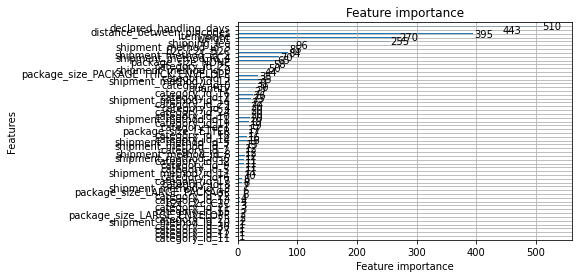

In [15]:
lgb.plot_importance(model)

In [16]:
feature_importances = {}

for importance, feature in zip(model.feature_importances_, model.feature_name_):
    feature_importances[feature] = importance

feature_importances

{'declared_handling_days': 510,
 'shipping_fee': 255,
 'item_price': 395,
 'quantity': 30,
 'weight': 270,
 'distance_between_pincodes': 443,
 'b2c_c2c_B2C': 85,
 'b2c_c2c_C2C': 4,
 'shipment_method_id_0': 50,
 'shipment_method_id_3': 96,
 'shipment_method_id_1': 20,
 'shipment_method_id_5': 16,
 'shipment_method_id_2': 84,
 'shipment_method_id_6': 12,
 'shipment_method_id_8': 12,
 'shipment_method_id_10': 2,
 'shipment_method_id_7': 13,
 'shipment_method_id_4': 70,
 'shipment_method_id_13': 7,
 'shipment_method_id_14': 23,
 'shipment_method_id_9': 0,
 'shipment_method_id_11': 11,
 'shipment_method_id_12': 35,
 'shipment_method_id_15': 0,
 'shipment_method_id_24': 0,
 'shipment_method_id_17': 0,
 'shipment_method_id_18': 0,
 'shipment_method_id_19': 0,
 'shipment_method_id_16': 0,
 'shipment_method_id_21': 0,
 'shipment_method_id_20': 0,
 'shipment_method_id_22': 0,
 'category_id_13': 4,
 'category_id_0': 31,
 'category_id_1': 19,
 'category_id_3': 35,
 'category_id_11': 1,
 'category_

In [17]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.1614
Testing accuracy 0.1574


In [18]:
# training_data["model_outputs"] = model.predict(training_data[cols_to_use])

In [19]:
modes_dict = {}
for col in training_data:
    modes_dict[col] = training_data[col].mode()

In [20]:
del training_data
quiz_data = preprocessing.read_data(rows_to_read = 2500000)["quiz"]

quiz_data = preprocessing.parse_datetime_columns(quiz_data)

quiz_data, generated_columns = preprocessing.one_hot_encode_columns(df = quiz_data, columns = cols_to_convert_to_one_hot)


Reading 2500000 rows.
Reading all columns.


In [21]:
# Filling in the blanks from non existing 

for col in model.feature_name_:
    if col not in quiz_data.columns:
        print("col : ", col)
        quiz_data[col] = modes_dict[col]

col :  distance_between_pincodes
col :  shipment_method_id_24
col :  shipment_method_id_19
col :  shipment_method_id_21
col :  shipment_method_id_20
col :  shipment_method_id_22
col :  package_size_EXTRA_LARGE_PACKAGE


In [22]:
quiz_data["model_outputs"] = model.predict(quiz_data[cols_to_use])

# Postprocessing

After this is all done and predicting with a decent accuracy this needs to be put back and the output needs to predict the delivery date.

The submission is a tsv table, which can be gzipped, with no headeron thw quiz dataset for now. After we win the first phase the test dataset will be given to us.

Each line should contain two values, first the record identifier from the distributed dataset, which is an integer, and second the predicted delivery date as a string in the format YYYY-MM-DD.

All records must be predicted.

In [23]:
output_columns_name = "predicted_delivery_date"

In [24]:
postprocessing.generate_output_column(df = quiz_data, 
                                      predicted_days_column="model_outputs",
                                     output_columns_name = output_columns_name)

In [29]:
quiz_data.shape

(2500000, 83)

In [25]:
postprocessing.generate_submission_file(df = quiz_data, predicted_dates_column="predicted_delivery_date")

# Double checking outputs

In [26]:
import pandas as pd

In [27]:
submission = pd.read_csv("./results/result_2021-12-19 00:30:37.tsv", sep='\t', header = None)

In [28]:
submission

,0,1
0,15000001,2019-11-18
1,15000002,2019-11-30
2,15000003,2019-12-06
3,15000004,2019-12-16
4,15000005,2019-12-22
...,...,...
2499995,17499996,2019-12-24
2499996,17499997,2019-12-09
2499997,17499998,2019-12-08
2499998,17499999,2019-12-12
